# Feature Selection



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5,1,'X v y')

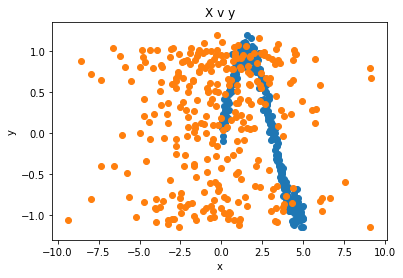

In [ ]:
x = np.linspace(0, 5, 300)
X = np.random.normal(0, 3, size = 300 * 2).reshape(300, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=300) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [7]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
model = pipeline.fit(X, y)

In [8]:
print("Feature Proportions", model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

Feature Proportions {0: 0.5007479431563201, 1: 0.20007479431563202}
Is Kept [ True False]


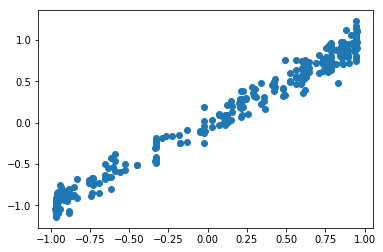

In [9]:
plt.scatter(model.predict(X), y)

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [ ]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=-1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.9, "local"), model)
pipeline_model = pipeline.fit(X, y)

In [ ]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

In [ ]:
plt.scatter(model.predict(X), y)

In [ ]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

In [ ]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

## Lower level API

If you want functionality not offered in the Sklearn API, or want to understand the internals, we can drop down into the BartPy API

## Create a benchmark null distribution

To identify whether features are important, we need a baseline "null" distribution to compare the inclusion proportions to.  To do this, we create a set of data where the target variable is randomly permuted to remove any relationship between the covariates and the target

In [4]:
null_distributions = null_feature_split_proportions_distribution(model, X, y, n_permutations=3)

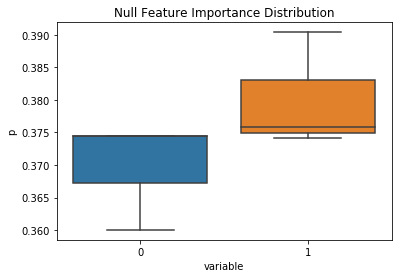

In [5]:
plot_null_feature_importance_distributions(null_distributions)

In [6]:
thresholds = local_thresholds(null_distributions, 0.95) 

## Fit BartPy to the true data

In [7]:
model.fit(X, y)

SklearnModel(alpha=0.95, beta=2.0, n_burn=50, n_chains=4, n_jobs=4,
       n_samples=1000, n_trees=50, p_grow=0.5, p_prune=0.5, sigma_a=0.001,
       sigma_b=0.001, store_in_sample_predictions=False, thin=0.1)

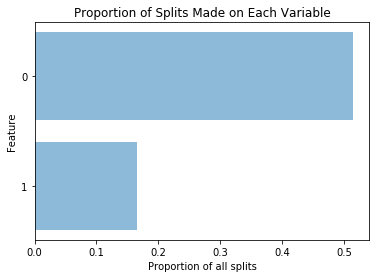

In [8]:
proportions = feature_split_proportions_counter(model.model_samples)
plot_feature_split_proportions(model.model_samples)

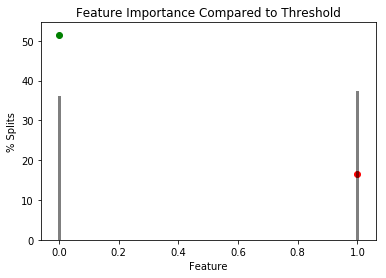

In [9]:
plot_feature_proportions_against_thresholds(proportions, thresholds)

In [10]:
final_features = kept_features(proportions, thresholds)
final_features

[0]